<a href="https://colab.research.google.com/github/biadeneedo/Text_Generation/blob/main/Data_Ingestion_%26Preprocessing_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Christmas Challenge - Data Preprocessing**

Besides the core modeling section we tried multiple techniques to better understand the available data and consequently improve the text generation models
- **Data Augementation**: Since we used deep non linear model we can clearly say the more data the better results. This phase has been indeed useful to increase the overall performance
- **Text Cleaning**: In this phase we handle the cleaning of the dataset, creating a new column called "Cleaned Text" which will be the input for our model
- **NLP Features**: We tried to calculate technical NLP features such as Lemmas and Token to use them in the models. However, since algorithms have to predict the exact word declination we had to stick the the results of the Text Cleaning section, whithout using NLP features.
- **Artist Key-Words**: Since the goal of the analysis is creating lyrics for Bublé, we had to understand which word uniquely identify each artist. As the frequency of word was not sufficient, we opted for logistic regression using artists as target variables and lyrics as indipendent variables
- **Clustering of Top Artist**: In order not to have a huge level of randomness in the dataset we clustered each top artist (defined by an high number of lyric rows in the dataset) following their lyrics, using a PCA to visualize the results. However, results have shown that it is not possible to indentify any distinct cluster  


### **Setup**

In [ ]:
# Tensorflow Libraries
%tensorflow_version 1.x # Import tensorflow version 1 if you want to run the textgenrnn model 
#import tensorflow as tf # Import tensorflow recent version if you want to run normal RNN models


# Basic Libraries
%tensorflow_version 1.x
import tensorflow as tf
from textgenrnn import textgenrnn
%load_ext google.colab.data_table
from google.colab import files, drive
import pandas as pd
import numpy as np
import re
import spacy
import en_core_web_sm
from tqdm import tqdm, tqdm_notebook 
import itertools
import seaborn as sns
import string
import nltk
import warnings
from datetime import datetime
import os
import io
from __future__ import print_function 
import numpy as np
import pandas as pd
import random
import sys

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#Keras
import keras
from keras.callbacks import LambdaCallback
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, Embedding, Flatten, TimeDistributed, Dropout
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from keras.utils import to_categorical, np_utils
from keras.callbacks import ModelCheckpoint, History, EarlyStopping 
from keras import backend

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=DeprecationWarning)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # Import tensorflow version 1 if you want to run the textgenrnn model`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# Import data to Colab
uploaded = files.upload()

Saving new_df.csv to new_df.csv


In [ ]:
# Read data
#data = pd.read_excel('xmas-songs.xlsx')
new_df = pd.read_csv('new_df.csv', delimiter= ';')
#spacy_df = pd.read_csv('spacy_df.csv', delimiter= ';')
#lyricsText = open('lyricsText.txt', 'r', encoding='utf-8').read()

### **1.Data Augmentation**

In [ ]:
!pip install lyricsgenius
import lyricsgenius 

In [ ]:
wiki_file = pd.read_html('https://en.wikipedia.org/wiki/List_of_popular_Christmas_singles_in_the_United_States', header=1)
Top_Christ_Songs = list(pd.DataFrame(wiki_file[1]).iloc[:,0])
Artists = list(pd.DataFrame(wiki_file[1]).iloc[:,1])

In [ ]:
client_access_token = '-niCks7Tvz9vHmoZR2Fb2v0EaiF8MCdm31PBmssEZrkr9jSwF3K6i-IXMuVPiUVA'
genius = lyricsgenius.Genius(client_access_token, remove_section_headers=True,
                 skip_non_songs=True, excluded_terms=["Remix", "Live", "Edit", "Mix", "Club"])

In [ ]:
# Acquiring additional song lyrics
# https://zpitenis.com/blog/post/mining-song-lyrics-from-genius/
artists = []
titles = []
albums = []
years = []
lyrics = []
for n in range(0,len(Top_Christ_Songs)):
    print(n)
    title = Top_Christ_Songs[n]
    #print(title)
    artist = Artists[n]
    #print(artist)  
    song = genius.search_song(title, artist)
    if song is not None:
        print('\nNow adding: Artist')
        artists.append(artist)
        print('Now adding: Title')
        titles.append(title)
        print('Now adding: Lyrics')
        lyrics.append(song)

In [ ]:
#Create a dataframe for our collected tracklist   
tracklist = pd.DataFrame({'Artist':artists, 'Title':titles, 'Lyrics':lyrics})   
tracklist.head()
#Save the final tracklist to csv format
new_df.to_csv('new_df.csv', sep= ';', index=False)

In [ ]:
data = data[['Artist','Title','Lyrics']].append(tracklist)

### **2.Text Cleaning**

In [ ]:
def preprocessing_songs(df):

  # Remove any songs with no lyric (aka non-instrumental songs)
  df = df[df['Lyrics'].notnull()]
  
  # Set an Index for all the lines 
  df['Lyric Line'] = df['Lyrics'].apply(lambda x: x.split('\n'))
  df = df.set_index(['Title', 'Artist'])['Lyric Line'].apply(pd.Series).stack().reset_index().drop('level_2',1)
  df.rename(columns={0:'Lyric Line'}, inplace=True)
  
  print('Removing quotes from song...')
  df['Title'] = df['Title'].apply(lambda x: remove_song_quotes(x))

  print('Counting the number of distinct lines in the lyrics.')
  df['Number Lines'] = df['Lyric Line'].apply(lambda x: number_lines(x))

  print('Counting the number of words in each song.')
  df['Number Words'] = df['Lyric Line'].apply(lambda x: number_words(x))

  print('Calculating the average number of words in each line.')
  df['Average Words Per Line'] = df.apply(lambda row: words_per_line(row['Number Lines'], row['Number Words']), axis=1)

  print('Counting the number of apostrophes in each song.')
  df['Number Apostrophes'] = df['Lyric Line'].apply(lambda x: apostrophe_count(x))

  print('Calculating the average number of words in each line.')
  df['Average Words Per Apostrophe'] = df.apply(lambda row: words_per_apostrophe(row['Number Words'], row['Number Apostrophes']), axis=1)

  print('Cleaning lyrics...')
  df['Cleaned Lyrics'] = clean_text(df, 'Lyric Line')

  return df


# Innested functions

def remove_song_quotes(song_row):
  # Removes any quotations around songs
  try:
    song_row = re.sub(r'"', '', song_row)
  except:
    pass

  return song_row

def number_lines(lyrics_row):
  # Counts the number of distinct lines in the lyrics
  try:
    number_lines = lyrics_row.count('\n') + 1
    return number_lines
  except:
    return 0

def number_words(lyrics_row):
  # Counts the number of words in each song
  try:
    list_of_words = lyrics_row.split()
    number_words = len(list_of_words)
    return number_words
  except:
    return 0

def words_per_line(number_lines_row, number_words_row):
    # Calculates the average words per line
    
    if number_words_row == 0:
        # Don't want to return np.nan, return 0
        return 0
    else:
        average_words_per_line = number_words_row / number_lines_row
        return average_words_per_line

def apostrophe_count(lyrics_row):
    # Counts the number of apostrophes
    
    try:
        number_apostrophes = lyrics_row.count("'")
        return number_apostrophes
    except:
        return 0

def words_per_apostrophe(number_words_row, number_apostrophes_row):
    # Calculates the average number of words used per apostrophe used
    
    if number_words_row == 0 or number_apostrophes_row == 0:
        # Don't want to return np.nan, return 0
        return 0
    else:
        average_words_per_apostrophe = number_words_row / number_apostrophes_row
        return average_words_per_apostrophe

def clean_text(df, df_column):
    """ 
    Removing line breaks, special characters.
    Setting all letters to lowercase -- EXCEPT for pronoun I, kept capitalized.
    """
    
    # Replacing line breaks with one space
    df['Cleaned Lyrics'] = df[df_column].str.replace(r"\n", " ")
    
    # Removing special characters
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r"[.,?!();:]", "")
    
    # Replace two spaces with one space
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r"  ", " ")
    
    # Lower-case all words
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.lower()
    
    # Upper-case the pronouns I -- this helps with Spacy Lemmatization
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r" i i ", " I I ")
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r" i ", " I ")
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r" i'", " I'")
    
    return df['Cleaned Lyrics']

In [ ]:
new_df = preprocessing_songs(data)
new_df.to_csv('new_df.csv', sep = ";", index_label= False)
files.download('new_df.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Removing quotes from song...
Counting the number of distinct lines in the lyrics.
Counting the number of words in each song.
Calculating the average number of words in each line.
Counting the number of apostrophes in each song.
Calculating the average number of words in each line.
Cleaning lyrics...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define a Text file with all the lyrics inside
with open('lyricsText.txt', 'w', encoding='utf-8') as filehandle:
  for listitem in new_df['Cleaned Lyrics']:
    filehandle.write('%s\n' % listitem)

### **3.NLP Features**

In [ ]:
# compiling the tokens and lemmas
def pre_processing_songs_nlp(df):
  print('Extracting NLP features...')

  df['NLP Features'] = df['Cleaned Lyrics'].progress_apply(lambda x: nlp_pipeline(x))

  df = df.dropna()

  df['Tokens'] = df['NLP Features'].apply(lambda x: x['tokens'])

  df['Lemmas'] = df['NLP Features'].apply(lambda x: x['lemmas'])

  df['Lemmas Text'] = df['Lemmas'].apply(lambda x: ' '.join(x))

  df = df.reset_index(drop=True)

  return df

def nlp_pipeline(text_document):
    """
    Takes in a string and runs it through Spacy's NLP pipeline consisting of a 
    Tokenizer, Tagger, Dependency Parser, Entity Recognizer, Text Categorizer.
    NLP features are then extracted from each Token's Spacy attributes.
    NLP features are then aggregated for the entire text_document and returned in a dictionary.
    Inputs: text_document (str): Text data
    Output:dict: Aggregated NLP features
    """
    
    # Create Spacy NLP pipeline
    nlp = en_core_web_sm.load() 
    
    # Check if text is not a string, if so return np.nan
    if type(text_document) != str:
        return np.nan
    
    # Run Spacy NLP pipeline on text_document, creates DOC object filled with tokens
    doc = nlp(text_document)

    # Tokenization
    tokens = [tok.orth_ for tok in doc]

    # Lemmatization
    lemmas = [tok.lemma_ for tok in doc]

    # Create counter dictionaries to collect counts of NLP features
    pos_counter = {}   # Coarse-grained part-of-speech
    tag_counter = {}   # Fine-grained part-of-speech.
    stop_counter = {}   # Stop word or not
    dep_counter = {}   # Syntactic dependency relation

    # Loop through each Token object contained in Doc object
    for token in doc:

        # Add token 'POS' to dictionary
        pos = "pos_" + token.pos_
        if pos in pos_counter.keys():
            pos_counter[pos] += 1
        else:
            pos_counter[pos] = 1

        # Add token 'TAG' to dictionary
        tag = "tag_" + token.tag_
        if tag in tag_counter.keys():
            tag_counter[tag] += 1
        else:
            tag_counter[tag] = 1

        # Add token 'STOP' to dictionary
        stop = "stop_" + str(token.is_stop)
        if stop in stop_counter.keys():
            stop_counter[stop] += 1
        else:
            stop_counter[stop] = 1

        # Add token 'DEP' to dictionary
        dep = "dep_" + token.dep_
        if dep in dep_counter.keys():
            dep_counter[dep] += 1
        else:
            dep_counter[dep] = 1

    # Combine NLP features into one dictionary
    nlp_dictionary = {'pos_counter' : pos_counter,
                      'tag_counter' : tag_counter,
                      'stop_counter' : stop_counter,
                      'dep_counter' : dep_counter,
                      'tokens' : tokens,
                      'lemmas' : lemmas}
    
    return nlp_dictionary

In [ ]:
new_df = pre_processing_songs_nlp(new_df)
new_df.to_csv('new_df.csv', sep = ";", index_label= False)
files.download('new_df.csv')

In [ ]:
# compiling important features that are brought out with spaCy
def nlp_features(df):
  # Create dataframe of syntactic dependency relation counts 'dep'
    df_dep = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'dep_counter'))
    df_dep = df_dep.fillna(value = 0)

    # Create dataframe of coarse-grained parts-of-speech counts 'pos'
    df_pos = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'pos_counter'))
    df_pos = df_pos.fillna(value = 0)

    # Create dataframe of stop word counts 'stop'
    df_stop = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'stop_counter'))
    df_stop = df_stop.fillna(value = 0)

    # Create dataframe of fine-grained parts-of-speech counts 'tag'
    df_tag = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'tag_counter'))
    df_tag = df_tag.fillna(value = 0)

    # Combine all NLP dataframes
    df_spacy = pd.concat([df_stop, df_pos, df_tag, df_dep], axis=1)

    df_spacy = df_spacy.reset_index(drop=True)

    return df_spacy


def nlp_dict_to_df(nlp_features, feature):
    """
    Take in nlp_features dictionary, outputs a pd.Series object 
    containing the NLP features.
    Inputs: nlp_features (dict): Aggregated NLP features.
    Outputs: nlp_series (pd.Series): NLP features for each song obtained using Spacy.
    """  
   
    # Dep dictionary
    nlp_dict = nlp_features[feature]

    # Total number of entries in dep dictionary
    nlp_total = np.sum(list(nlp_dict.values()))

    # Calculate fraction of total for each NLP feature (Normalization)
    nlp_dict_fractions = {k: v / nlp_total for k, v in nlp_dict.items()}

    # Turn into a pandas Series to return
    nlp_series = pd.Series(nlp_dict_fractions)
    
    return nlp_series


In [ ]:
spacy_df = nlp_features(new_df)
spacy_df.to_csv('spacy_df.csv', sep = ";", index_label= False)
files.download('spacy_df.csv')

### **4.Artists' Key-Words**

The Logistic Regression has been used to predict which words are most connected to each Artist, using only the lyrics as the independent variable

In [ ]:
df = new_df.dropna()
y = df['Artist']
X = df['Cleaned Lyrics']

# Vocabulary Definition
words = []
for row in X:
      new_words = str(row).split()
      words = words + new_words
len(words)
vocabulary = set(words)
vocabulary.remove('[')
vocabulary.remove(']')
vocabulary.remove('-')
vocabulary.remove("""'""")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 444)
count_vectorizer = CountVectorizer(vocabulary=vocabulary)

In [ ]:
# Pipeline
clf = Pipeline(steps=
                    [('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),])

# Run the grid search 
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [ ]:
# Predicts usings the best parameters of the grid search
y_pred = clf.predict(X_test)

# Accuracy Score
clf.score(X_train, y_train)
clf.score(X_test, y_test)
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))
print()

# Classification Report
print(classification_report(y_test, y_pred, digits=3))
print()

# Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print()

Accuracy Score:
0.2825138201920279

                                                   precision    recall  f1-score   support

                              "Weird Al" Yankovic      0.556     0.333     0.417        15
                                          'N Sync      0.161     0.462     0.239        52
                                       98 Degrees      0.000     0.000     0.000         1
                                              98°      0.000     0.000     0.000         7
                                             ABBA      1.000     0.286     0.444         7
                                     Aaron Tippin      0.000     0.000     0.000         6
                                       Al Stewart      1.000     0.167     0.286         6
                                          Alabama      0.233     0.368     0.286        19
                                     Alan Jackson      0.302     0.419     0.351        31
                                  Alexandra Burke    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf.named_steps['clf'].coef_

array([[-0.00378926, -0.02069484, -0.01812725, ..., -0.01019999,
        -0.0038458 , -0.00727509],
       [-0.0145577 , -0.03344243, -0.03676412, ..., -0.00997764,
        -0.00913567, -0.01711834],
       [-0.00011992, -0.00061934, -0.00072314, ..., -0.00028301,
        -0.0001497 , -0.00028545],
       ...,
       [-0.001375  , -0.00530215, -0.00586881, ..., -0.00304703,
        -0.00135312, -0.00257312],
       [-0.00171884, -0.00664989, -0.0059934 , ..., -0.00353201,
        -0.00140698, -0.0026754 ],
       [-0.00152714, -0.00865804, -0.0100137 , ..., -0.00283992,
        -0.00189526, -0.00360177]])

In [ ]:
for i,el in enumerate(clf.named_steps['clf'].coef_[class_index]):
  print(i)
  print(el)

Streaming output truncated to the last 5000 lines.
1939
-0.006629184002577864
1940
-0.005645546405457476
1941
-0.008327436349706157
1942
-0.0013695117377210636
1943
-0.007054771252855418
1944
-0.03573443775440958
1945
-0.014363369729393753
1946
-0.001699680426349408
1947
-0.02290774258892089
1948
-0.00486746434975836
1949
-0.010938049943012272
1950
-0.0032926996705989354
1951
0.4938336446101868
1952
-0.096469032085891
1953
-0.0023734841592865387
1954
-0.0014516891782196612
1955
-0.0023589852247262485
1956
-0.24494716960806784
1957
-0.006831490746520857
1958
-0.0022493855214648236
1959
-0.0033024128305911963
1960
-0.004384504608605472
1961
-0.019133512235459407
1962
-0.8494725769411
1963
-0.005766338286611191
1964
-0.004631164034212024
1965
-0.024014141680309496
1966
-0.0017092099490558798
1967
-0.001198422686289292
1968
-0.008832890290228617
1969
-0.0013826043630285043
1970
-0.0015157703972865984
1971
-0.0072960774840361165
1972
-0.0014259910668216746
1973
-0.00655212254886455
1974
-0.

In [ ]:
index_to_word

{'perrie': 0,
 'melt': 1,
 "'auld": 2,
 'king': 3,
 'bill': 4,
 'number': 5,
 'cherry': 6,
 'cuddle': 7,
 'mm': 8,
 'stormy': 9,
 'own': 10,
 'prancing': 11,
 'check': 12,
 'beard': 13,
 'pushy': 14,
 "weather's": 15,
 'chimed': 16,
 'they’re': 17,
 'seaside': 18,
 'pot': 19,
 'upset': 20,
 'boarded': 21,
 'wing': 22,
 'last-minute': 23,
 "vixen's": 24,
 "you're": 25,
 'families': 26,
 'ways': 27,
 'heights': 28,
 'meaning': 29,
 'reminiscing': 30,
 'darkening': 31,
 'unfaithful': 32,
 'snowflake': 33,
 "soldier's": 34,
 'animals': 35,
 'sound': 36,
 "longin'": 37,
 'tv': 38,
 'john': 39,
 'flat': 40,
 "time's": 41,
 'appearing': 42,
 'dob': 43,
 'froze': 44,
 'lifetime': 45,
 'fart': 46,
 "dad's": 47,
 'bugged': 48,
 "dancin'": 49,
 'failed': 50,
 'swayed': 51,
 'sandy': 52,
 'baby': 53,
 'sealed': 54,
 'sweeter': 55,
 'green': 56,
 'circus': 57,
 'mailman': 58,
 'sung': 59,
 'rejoice': 60,
 'saddle': 61,
 'constellation': 62,
 'packs': 63,
 'wanted': 64,
 'six': 65,
 'becky': 66,
 'r

In [ ]:
 def get_most_important_features(vectorizer, model, n=5):
    """
    This function is used to find the most important ngrams (words) 
    for classifying each class (songwriter).
    
    Args:
        vectorizer (sklearn.feature_extraction.text.CountVectorizer):
        The vectorizer used to create the Bag of Words space matrix.
        model (sklearn.linear_model.logistic.LogisticRegression):
        The LR model trained on the dataset.
        n (int): Number of top words to return.
    
    Returns:
        important_words (dict): Dicitionary containing the most
        critical words used to predict each songwriter class.
    """
    
    # Create a mapping dictionary from words to index
    index_to_word = word_to_index = {w: i for i, w in enumerate(vocabulary)}
    
    # loop for each class
    important_words = {}
    for class_index in range(model.named_steps['clf'].coef_.shape[0]): #number of Artists
        word_importances = [(el, list(index_to_word)[i]) for i,el in enumerate(model.named_steps['clf'].coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        important_words[class_index] = {'tops':tops, 'bottom':bottom}
    
    return important_words

In [ ]:
# Vectorize
vectorizer = CountVectorizer(max_df = 0.1, ngram_range = (1, 2))

# Find the most important words used for classification
importance = get_most_important_features(vectorizer, clf, 10)

# Re-name the dictionary keys
importance['Garth Brooks'] = importance.pop(0)
importance['James Brown'] = importance.pop(1)
importance['Mariah Carey'] = importance.pop(2)
importance['Michael Buble'] = importance.pop(3)

# Print the most important words
importance['Garth Brooks']

{10: {'bottom': [(-0.37546046383499637, 'line'),
   (-0.40128078244243953, "should've"),
   (-0.4861666947057059, '"thanks'),
   (-0.4913736783959976, 'crappy'),
   (-0.5567848456136713, 'usual'),
   (-0.5611783957604998, 'searchers'),
   (-0.5887148696045308, 'pulled'),
   (-0.6473408881641524, 'slighest'),
   (-1.1258548408453315, 'dim'),
   (-1.3855570442778624, 'tear')],
  'tops': [(1.689365242843791, '[spoken'),
   (1.8553720309674182, 'enthuse'),
   (1.858372570691976, 'called'),
   (2.1693782738065464, 'sometimes'),
   (2.1912012523899826, 'hot'),
   (2.3561535582490687, 'melts'),
   (2.401976396868849, 'foot'),
   (2.48801793187885, 'designer'),
   (3.8489236638923736, 'homeward'),
   (3.9041261378027095, "wind's")]},
 100: {'bottom': [(-0.10660552813987448, 'pulled'),
   (-0.10854000307221358, 'searchers'),
   (-0.10940647543148081, "smilin'"),
   (-0.11088611240320598, 'usual'),
   (-0.11178690721873576, '"thanks'),
   (-0.11869427917714571, 'slighest'),
   (-0.12309712309929

In [ ]:
# Print the most important words
importance['Michael Buble']

{'bottom': [(-0.2530127814516946, 'question'),
  (-0.2591733225594369, 'snowflakes'),
  (-0.26236970401739174, 'here'),
  (-0.3310458927211854, 'carols'),
  (-0.3491081182988111, 'designer'),
  (-0.3519574786611362, 'didn’t'),
  (-0.3524621746946363, 'pulled'),
  (-0.3546213642659551, 'fl-y-y-y-y'),
  (-0.4083666492946759, "smilin'"),
  (-0.7120057225561994, 'tear')],
 'tops': [(1.070120853131674, '[bridge'),
  (1.0954570071138392, 'believe'),
  (1.114765535114411, 'nick'),
  (1.1586728317923247, 'forgiving'),
  (1.4085778649319471, 'recalling'),
  (1.6756427374777003, 'around"'),
  (1.8096474572697874, "that'd"),
  (1.910243020239799, 'dew'),
  (2.567979612696838, 'stops'),
  (2.910203184731578, 'rides')]}

### **5.Clustering of Top Artists** 

The Latent Sematic Analysis is useful in trying to differentiate the top Artists from each other based on the distribution of their most frequent words. We start ebbedding words using a common bag of word approach while, since it’s impossible to plot a graph based on anything over 3 dimensions, we need to use a process called singular value decomposition to cut it down to 2 dimensions

In [ ]:
# Define X and y
y = new_df['Artist']
X = new_df['Lemmas Text']

# Vocabulary Definition
words = []
for row in X:
      new_words = str(row).split()
      words = words + new_words
len(words)
vocabulary = set(words)
vocabulary.remove('[')
vocabulary.remove(']')
vocabulary.remove('-')
vocabulary.remove("""'""")

# Count vectorizer and the index-to-word mapping
count_vectorizer = CountVectorizer(vocabulary=vocabulary, token_pattern=r"\b\w+\b")

# Create bag-of-word embeddings using vectorizer
X_counts = count_vectorizer.fit_transform(X.astype(str))
X_counts = pd.DataFrame(X_counts.todense())

# Create a mapping from index-to-word for the bag of words
index_to_word = {v:k for k,v in count_vectorizer.vocabulary_.items()}
np.count_nonzero(X_counts)
X_counts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3716,3717,3718,3719,3720,3721,3722,3723,3724,3725,3726,3727,3728,3729,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739,3740,3741,3742,3743,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754,3755
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
le = LabelEncoder()
le.fit(y)
y_encoded = le.transform(y)

def plot_LSA(test_data, test_labels, plot=True):
    """
    This function first uses SK-Learn's truncated SVD (LSA) class to 
    transform the high dimensionality (number of columns) of the BoW 
    embedding down to 2 dimensions. Then the two dimensions are used
    to plot each song, colored by the song writer (class)
    """
    
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['blue','green','purple', 'red']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        blue_patch = mpatches.Patch(color='blue', label='Garth Brooks')
        green_patch = mpatches.Patch(color='green', label='James Brown')
        purple_patch = mpatches.Patch(color='purple', label='Mariah Carey')
        orange_patch = mpatches.Patch(color='red', label='Michael Bublé')
        plt.legend(handles=[blue_patch, green_patch, purple_patch, orange_patch], prop={'size': 18})
        plt.xlabel('Principal Component One')
        plt.ylabel('Principal Component Two')
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20

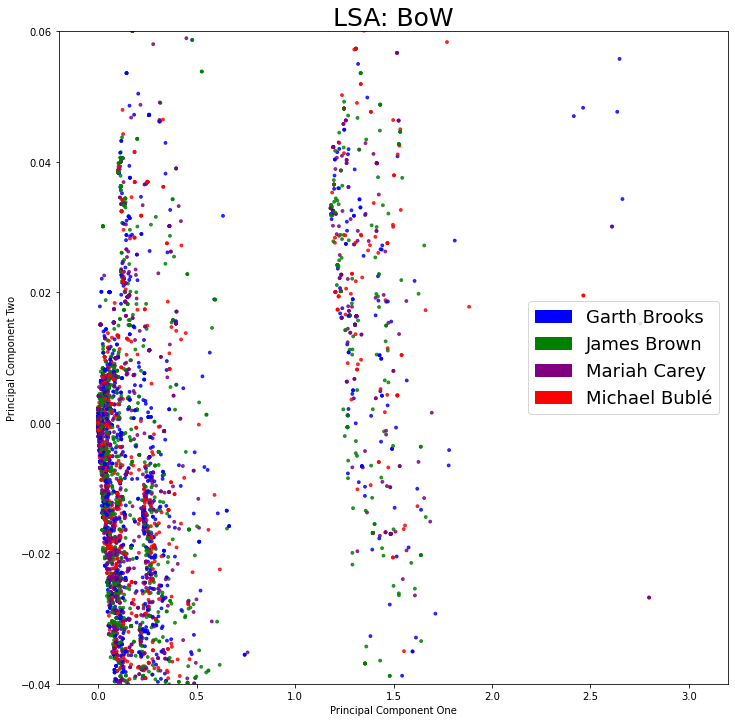

In [ ]:
# Run LSA on BoW embeddings and plot it
fig = plt.figure(figsize=(12, 12))
plot_LSA(X_counts, y_encoded)
plt.title('LSA: BoW', fontsize = 25)
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["axes.labelsize"] = 20
plt.xlim(-0.2, 3.2)
plt.ylim(-0.04, 0.06)
plt.show()